<a href="https://colab.research.google.com/github/wsgkelv/ghana-voter-id-detector/blob/main/Imageidentifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
from google.colab import drive
drive.mount('/content/drive')

# Base project folder in your Drive
BASE_DIR = "/content/drive/MyDrive/gh_voter_detector"
DATA_DIR = f"{BASE_DIR}/data"

MODEL_H5_PATH = f"{BASE_DIR}/voter_id_model.h5"       # optional full model
WEIGHTS_PATH = f"{BASE_DIR}/voter_id_weights.h5"      # weights only

print("BASE_DIR:", BASE_DIR)
print("DATA_DIR:", DATA_DIR)
print("Model (optional) will be saved to:", MODEL_H5_PATH)
print("Weights will be saved to:", WEIGHTS_PATH)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
BASE_DIR: /content/drive/MyDrive/gh_voter_detector
DATA_DIR: /content/drive/MyDrive/gh_voter_detector/data
Model (optional) will be saved to: /content/drive/MyDrive/gh_voter_detector/voter_id_model.h5
Weights will be saved to: /content/drive/MyDrive/gh_voter_detector/voter_id_weights.h5


In [31]:
import os

print("Contents of BASE_DIR:")
print(os.listdir(BASE_DIR) if os.path.exists(BASE_DIR) else "BASE_DIR not found")

print("\nContents of DATA_DIR:")
print(os.listdir(DATA_DIR) if os.path.exists(DATA_DIR) else "DATA_DIR not found")


Contents of BASE_DIR:
['data', 'voter_id_model.h5', 'voter_id_model.keras', 'voter_id.weights.h5']

Contents of DATA_DIR:
['voter_id', 'voter_id_augmented']


In [32]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [33]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 8

train_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
print("Class names:", class_names)   # should be ['other', 'voter_id'] or similar

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)


Found 334 files belonging to 2 classes.
Using 268 files for training.
Found 334 files belonging to 2 classes.
Using 66 files for validation.
Class names: ['voter_id', 'voter_id_augmented']


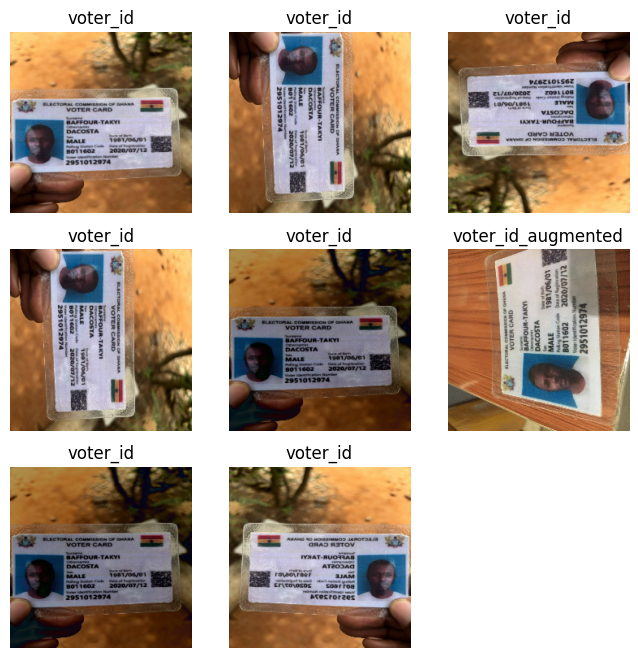

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(min(9, images.shape[0])):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [35]:
def build_model():
    # Data augmentation (same as what we’ll use in Streamlit)
    data_augmentation = tf.keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.05),
            layers.RandomZoom(0.1),
        ],
        name="data_augmentation",
    )

    base_model = MobileNetV2(
        input_shape=IMG_SIZE + (3,),
        include_top=False,
        weights="imagenet"
    )
    base_model.trainable = False   # freeze base model

    inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
    x = data_augmentation(inputs)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation="sigmoid")(x)  # binary: voter_id vs other

    model = Model(inputs, outputs)
    return model

model = build_model()
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_2 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_2 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [36]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

EPOCHS = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 16s 344ms/step - accuracy: 0.6436 - loss: 0.6717 - val_accuracy: 0.9091 - val_loss: 0.3246
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 291ms/step - accuracy: 0.8468 - loss: 0.3773 - val_accuracy: 0.9242 - val_loss: 0.2778
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 337ms/step - accuracy: 0.8527 - loss: 0.3592 - val_accuracy: 0.9242 - val_loss: 0.2702
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 330ms/step - accuracy: 0.8759 - loss: 0.3649 - val_accuracy: 0.9242 - val_loss: 0.2702
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 312ms/step - accuracy: 0.8811 - loss: 0.3489 - val_accuracy: 0.9242 - val_loss: 0.2712
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 327ms/step - accuracy: 0.8828 - loss: 0.3193 - val_accuracy: 0.9242 - val_loss: 0.2679
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 343ms/step - accuracy: 0.8892 - loss: 0.3129 - val_accuracy: 0.9242 - val_loss: 0.2693
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 336ms/step - accuracy: 0.8734 - loss: 0.3087 - val_accu

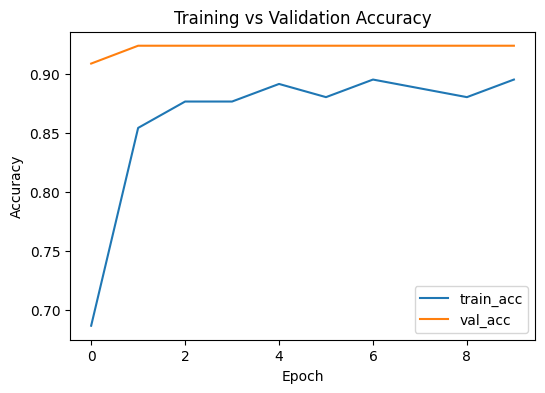

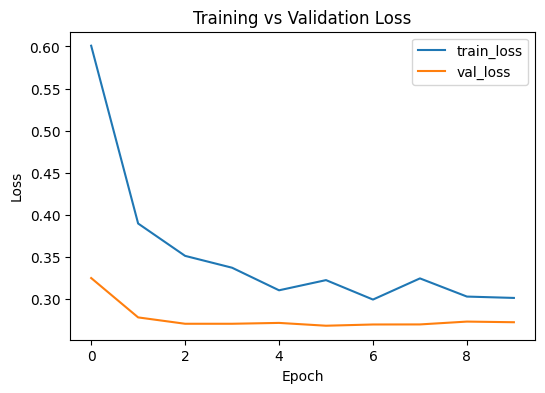

In [37]:
# Accuracy
plt.figure(figsize=(6, 4))
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

# Loss
plt.figure(figsize=(6, 4))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


In [38]:
BASE_DIR = "/content/drive/MyDrive/gh_voter_detector"
DATA_DIR = f"{BASE_DIR}/data"

MODEL_H5_PATH = f"{BASE_DIR}/voter_id_model.h5"          # optional full model
WEIGHTS_PATH = f"{BASE_DIR}/voter_id.weights.h5"         # ✅ ends with .weights.h5

print("BASE_DIR:", BASE_DIR)
print("DATA_DIR:", DATA_DIR)
print("Model (optional) will be saved to:", MODEL_H5_PATH)
print("Weights will be saved to:", WEIGHTS_PATH)


BASE_DIR: /content/drive/MyDrive/gh_voter_detector
DATA_DIR: /content/drive/MyDrive/gh_voter_detector/data
Model (optional) will be saved to: /content/drive/MyDrive/gh_voter_detector/voter_id_model.h5
Weights will be saved to: /content/drive/MyDrive/gh_voter_detector/voter_id.weights.h5


In [39]:
# Full model (optional warning is fine)
model.save(f"{BASE_DIR}/voter_id_model.keras")  # New Keras format
print("Full model saved as voter_id_model.keras")

# SAVE WEIGHTS – MUST END WITH `.weights.h5`
WEIGHTS_PATH = f"{BASE_DIR}/voter_id.weights.h5"   # 💡 IMPORTANT
model.save_weights(WEIGHTS_PATH)
print("Weights saved to:", WEIGHTS_PATH)


Full model saved as voter_id_model.keras
Weights saved to: /content/drive/MyDrive/gh_voter_detector/voter_id.weights.h5


In [40]:
from google.colab import files
files.download(WEIGHTS_PATH)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [41]:
import numpy as np
from PIL import Image
import os

# Example: pick one file from voter_id or other
test_image_path = os.path.join(DATA_DIR, "voter_id", os.listdir(os.path.join(DATA_DIR, "voter_id"))[0])
print("Testing on:", test_image_path)

img = Image.open(test_image_path).convert("RGB")
img_resized = img.resize(IMG_SIZE)
x = np.array(img_resized)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = np.expand_dims(x, axis=0)

prob = float(model.predict(x)[0][0])
print(f"Predicted probability of being VOTER ID: {prob:.4f}")


Testing on: /content/drive/MyDrive/gh_voter_detector/data/voter_id/photo_2025-11-13_16-40-52.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 888ms/step
Predicted probability of being VOTER ID: 0.8893


In [42]:
import os
import cv2
import numpy as np
from google.colab import drive

drive.mount('/content/drive')

input_folder = "/content/drive/MyDrive/gh_voter_detector/data/voter_id"
output_folder = "/content/drive/MyDrive/gh_voter_detector/data/voter_id_augmented"
os.makedirs(output_folder, exist_ok=True)

def augment_image(img):
    h, w = img.shape[:2]

    # rotations
    rotated = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    rotated2 = cv2.rotate(img, cv2.ROTATE_180)
    rotated3 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)

    # brightness
    bright = cv2.convertScaleAbs(img, alpha=1.2, beta=50)
    dark = cv2.convertScaleAbs(img, alpha=0.8, beta=-30)

    return [rotated, rotated2, rotated3, bright, dark]

count = 0
for filename in os.listdir(input_folder):
    img_path = os.path.join(input_folder, filename)
    img = cv2.imread(img_path)

    if img is None:
        continue

    aug_images = augment_image(img)
    for i, aug in enumerate(aug_images):
        save_path = os.path.join(output_folder, f"{filename.split('.')[0]}_aug{i}.jpg")
        cv2.imwrite(save_path, aug)
        count += 1

print(f"AUGMENTED IMAGES CREATED: {count}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
AUGMENTED IMAGES CREATED: 945


In [43]:
import cv2
import os

# PATH NOW IN COLAB
img_path = "/content/drive/MyDrive/gh_voter_detector/data/voter_id/photo_2025-11-13_16-43-34.jpg"

# Load the image
img = cv2.imread(img_path)
if img is None:
    raise Exception(f"Image not found at {img_path}")

# Create output folder for augmented images
output_folder = "/content/drive/MyDrive/gh_voter_detector/data/voter_id/"
os.makedirs(output_folder, exist_ok=True)

# Augment image function
def augment_and_save(img, name_prefix):
    transforms = [
        cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE),
        cv2.rotate(img, cv2.ROTATE_180),
        cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE),
        cv2.convertScaleAbs(img, alpha=1.3, beta=30),   # brighter
        cv2.convertScaleAbs(img, alpha=0.8, beta=-30),  # darker
        cv2.GaussianBlur(img, (5, 5), 0),               # blur
        cv2.flip(img, 0),                               # vertical flip
        cv2.flip(img, 1),                               # horizontal flip
    ]

    for i, t in enumerate(transforms):
        cv2.imwrite(os.path.join(output_folder, f"{name_prefix}_aug{i}.jpg"), t)

# Create 20 augmented copies
for i in range(20):
    augment_and_save(img, f"voter_aug_{i}")

print("Augmented images successfully saved in voter_id folder!")


Augmented images successfully saved in voter_id folder!
